In [2]:
import torch
from torchvision import datasets
from torch import nn, optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from pathlib import Path
import skimage
import cv2
import sklearn.neighbors as sk
from torch.utils.tensorboard import SummaryWriter
import pickle
import sklearn.cluster

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
writer = SummaryWriter(log_dir='runs/sequential_model')

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.ToTensor()
])

In [5]:
img_path = Path('val2017/')
try :
  with open('files_list.pkl', 'rb') as f:
      files = pickle.load(f)
except :
  files = sorted(img_path.iterdir())
  for image_path in files:
    img_rgb = Image.open(image_path)
    if np.array(transform(img_rgb)).shape !=(128,128,3):
        files.remove(image_path)

In [5]:
def compute_pixel(files, image_path): # Compute les pixels de l'image pour pouvoir regarder la répartition des tuples Lab dans l'espace CIE
  first_round =True
  for i, image_path in enumerate(files):
      img_rgb = np.array(transform(Image.open(image_path)))
      image_lab = skimage.color.rgb2lab(img_rgb)[:,:,1:]
      if first_round == False:
          previous_data = np.concatenate((previous_data, image_lab.reshape(-1,2)), axis=0)
      else :
          previous_data = image_lab.reshape(-1,2)
          first_round = False
      if i in [100, 250, 500, 1000, 2000, 3000, 4000]:
          print(i)


In [5]:
with open('all_pixels.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    previous_data = pickle.load(f)

In [ ]:
def compute_cluster(): # Pour obtenir des clusters à passer au model mais c'est pas la meilleur méthode et ca prend 30 min à calculer
  try :
    with open('clusters_centers.pkl', 'rb') as f:
      cluster_center = pickle.load(f)
  except :
    try :
      with open('all_pixels.pkl', 'rb') as f:
        previous_data = pickle.load(f)
    except :
      compute_pixel(files)
      with open('all_pixels.pkl', 'wb') as f:
        pickle.dump(previous_data, f)

    k_algorithm = sklearn.cluster.KMeans(n_clusters = 313)
    clusters = k_algorithm.fit(previous_data).cluster_centers_
    with open('clusters_centers.pkl', 'rb') as f:
      cluster_center = pickle.load(f)
  return clusters

In [6]:
clusters = np.load("pts_in_hull.npy") # Utitliser les clusters déjà calculé par l'article (avec une meilleur méthode)
# clusters = compute_cluster()

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform
        print("len : ", len(self.image_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_rgb = Image.open(self.image_paths[idx])
        img_rgb = np.array(self.transform((img_rgb)))
        image_lab = skimage.color.rgb2lab(img_rgb)
        image_input = image_lab[:, :,0]
        image_input = np.reshape(image_input, [1, 128, 128])
        image_output = image_lab[:,:, 1:]
        image_output = np.swapaxes(np.swapaxes(image_output, 0, 2), 1, 2)
        return torch.from_numpy(image_input/100), torch.from_numpy(image_output)


In [8]:
real_training_set = CustomDataset(image_paths = files, transform=transform)

len :  4990


In [9]:
data_loader_lab = DataLoader(real_training_set, batch_size=5, shuffle=True)

In [75]:
class NeuralNetwork(nn.Module):
    def __init__(self, clusters, lab_mode=True):

        super().__init__()
        self.cluster_centers = clusters
        self.criterion = nn.CrossEntropyLoss()
        if lab_mode == True :
          nb_final_channel = 2
        else :
          nb_final_channel = 3

        """
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(16,16)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels= 64, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(32,32)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels= 32, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(64,64)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=nb_final_channel, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(128,128)),
            nn.Sigmoid()
        )
        """
        self.linear_relu_stack = nn.Sequential(
           nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=64),
           nn.MaxPool2d(kernel_size=(2,2)),
           nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=128),
           nn.MaxPool2d(kernel_size=(2,2)),
           nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.UpsamplingNearest2d(size =(64,64)),
           nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
           nn.ReLU(),
           nn.BatchNorm2d(num_features=256),
           nn.UpsamplingNearest2d(size =(128,128)),
           nn.Conv2d(in_channels=256, out_channels=313, kernel_size=(1,1)),
           nn.Softmax(dim = 1)
          )
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def soft_encode_ab_batch(self, target, NN=5, sigma=5.0):
      nbrs = sk.NearestNeighbors(n_neighbors=NN, algorithm='ball_tree').fit(self.cluster_centers)
      N, _, H, W = target.shape
      K = self.cluster_centers.shape[0]
      ab_flat = torch.transpose(target, 1, 3).reshape(-1, 2)
      dists, inds = nbrs.kneighbors(ab_flat)
      weights = np.exp(-dists**2 / (2 * sigma**2))
      weights /= np.sum(weights, axis=1, keepdims=True)
      soft_encoded_flat = np.zeros((ab_flat.shape[0], K), dtype=np.float32)
      for i in range(NN):
          soft_encoded_flat[np.arange(ab_flat.shape[0]), inds[:, i]] = weights[:, i]
      soft_encoded = soft_encoded_flat.reshape(N, H, W, K).transpose(0, 3, 1, 2)

      return torch.from_numpy(soft_encoded)

    def one_hot_encode(self, target):
      nbrs = sk.NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(self.cluster_centers)
      N, _, H, W = target.shape
      K = self.cluster_centers.shape[0]
      ab_flat = torch.transpose(target, 1, 3).reshape(-1, 2)
      _ , inds = nbrs.kneighbors(ab_flat)
      self.classes = inds[:, 0]
      one_hot_encoded_flat = np.zeros((ab_flat.shape[0], K), dtype=np.float32)
      one_hot_encoded_flat[np.arange(ab_flat.shape[0]), inds[:, 0]] = 1
      one_hot_encoded = one_hot_encoded_flat.reshape(N, H, W, K).transpose(0, 3, 1, 2)

      return torch.from_numpy(one_hot_encoded)

    def custom_function(self, x):
      return self.cluster_centers[x.to('cpu')]

    def reverse_encode_ab_batch(self, batch_image):
        batch_q=  torch.argmax(batch_image, dim=1).to(device)
        result = self.custom_function(batch_q)
        print(result.shape)
        return result

    def predict_image(self, input):
       outputs = self.forward(input)
       ab_output = self.reverse_encode_ab_batch(outputs)
       print(ab_output.shape)
       return ab_output


    def forward(self, x):
      logits = self.linear_relu_stack(x)
      return logits
        

    def fit(self, data_loader, num_epochs=10):
      for epoch in range(num_epochs):
        self.train() # Surtout nécessaire si on fait du dropout ou de la batch normalisation
        epoch_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = self.forward(inputs.float())
            # targets_soft_encoded = self.on(targets).float().to(device)
            targets_one_hot_encode = self.one_hot_encode(targets).float().to(device)
            loss = self.criterion(outputs, targets_one_hot_encode)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        writer.add_scalar('Loss/train', loss.item(), epoch)
        print(f"Époque {epoch + 1}/{num_epochs}, Perte moyenne: {epoch_loss / len(data_loader):.4f}")
      writer.close()

    def overfit(self, input, target, data_loader, num_epochs=1):
      self.train() # Surtout nécessaire si on fait du dropout ou de la batch normalisation
      inputs = input.to(device)
      self.input = inputs
      for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(200):      
          outputs = self.forward(inputs.float())
          # targets_soft_encoded = self.on(targets).float().to(device)
          targets_one_hot_encode = self.soft_encode_ab_batch(target).float().to(device)
          loss = self.criterion(outputs, targets_one_hot_encode)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          epoch_loss += loss.item()
        print(f"Époque {epoch + 1}/{num_epochs}, Perte moyenne: {epoch_loss / len(data_loader):.4f}")

In [76]:
model = NeuralNetwork(clusters).to(device)

In [18]:
for i, (name, layer) in enumerate(model.named_children()):
    if i == 1 :
        print(layer[0])
        print(layer[4])
        print(layer[8])
        print(layer[11])
        print(layer[14])
        print(layer[17])
        print(layer[20])
        print(layer[24])
        print(layer[28])

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 313, kernel_size=(1, 1), stride=(1, 1))


In [12]:
def activation_hook(module, input, output,i):
    i =np.random.randint(0, high= 500)
    writer.add_histogram(f'activation/{module.__class__.__name__}{i}', output, global_step=0)
 


def gradient_hook(module, grad_input, grad_output, i):
    i =np.random.randint(0, high =500)
    writer.add_histogram(f'gradient/{module.__class__.__name__}{i}', grad_output[0], global_step=0)

for i, (name, layer) in enumerate(model.named_children()):
    if i == 1 :
        layer[0].register_forward_hook(lambda module, input, output, idx=0: activation_hook(module, input, output, idx))
        layer[4].register_forward_hook(lambda module, input, output, idx=1: activation_hook(module, input, output, idx))
        layer[8].register_forward_hook(lambda module, input, output, idx=2: activation_hook(module, input, output, idx))
        layer[11].register_forward_hook(lambda module, input, output, idx=3: activation_hook(module, input, output, idx))
        layer[14].register_forward_hook(lambda module, input, output, idx=4: activation_hook(module, input, output, idx))
        layer[17].register_forward_hook(lambda module, input, output, idx=5: activation_hook(module, input, output, idx))
        layer[24].register_forward_hook(lambda module, input, output, idx=6: activation_hook(module, input, output, idx))
        layer[28].register_forward_hook(lambda module, input, output, idx=7: activation_hook(module, input, output, idx))
        
        layer[0].register_full_backward_hook(lambda module, input, output, idx=0: gradient_hook(module, input, output, idx))
        layer[4].register_full_backward_hook(lambda module, input, output, idx=1: gradient_hook(module, input, output, idx))
        layer[8].register_full_backward_hook(lambda module, input, output, idx=2: gradient_hook(module, input, output, idx))
        layer[11].register_full_backward_hook(lambda module, input, output, idx=3: gradient_hook(module, input, output, idx))
        layer[14].register_full_backward_hook(lambda module, input, output, idx=4: gradient_hook(module, input, output, idx))
        layer[17].register_full_backward_hook(lambda module, input, output, idx=5: gradient_hook(module, input, output, idx))
        layer[24].register_full_backward_hook(lambda module, input, output, idx=6: gradient_hook(module, input, output, idx))
        layer[28].register_full_backward_hook(lambda module, input, output, idx=7: gradient_hook(module, input, output, idx))

In [69]:
for input, target in data_loader_lab:
    input =input.to(device)
    targets = target
    break

In [77]:
# model = torch.load("model_avec_real_data_et_argmax_10epoch_val_set.pth").to(device)
model.overfit(input, targets, data_loader_lab, num_epochs=10)

Époque 1/10, Perte moyenne: 1.0985
Époque 2/10, Perte moyenne: 1.0919
Époque 3/10, Perte moyenne: 1.0909
Époque 4/10, Perte moyenne: 1.0894
Époque 5/10, Perte moyenne: 1.0887
Époque 6/10, Perte moyenne: 1.0882
Époque 7/10, Perte moyenne: 1.0868
Époque 8/10, Perte moyenne: 1.0858
Époque 9/10, Perte moyenne: 1.0853
Époque 10/10, Perte moyenne: 1.0852


In [19]:
model.fit(data_loader_lab, num_epochs=2)

Époque 1/2, Perte moyenne: 5.4220
Époque 2/2, Perte moyenne: 5.4221


In [17]:
points  = model.cluster_centers[model.classes].T
cluster = model.cluster_centers.T

In [21]:
points.shape

(2, 81920)

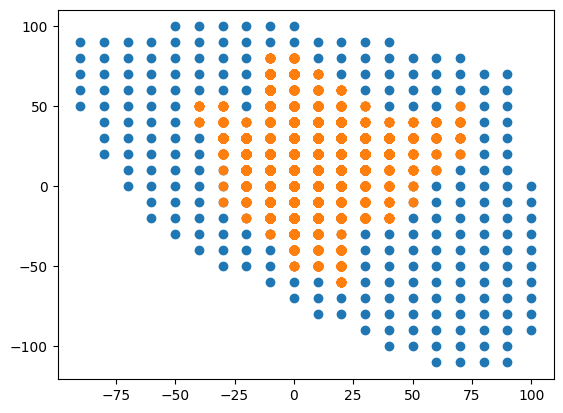

In [19]:
plt.scatter(cluster[0], cluster[1])
plt.scatter(points[0], points[1])

(5, 128, 128, 2)
(5, 128, 128, 2)


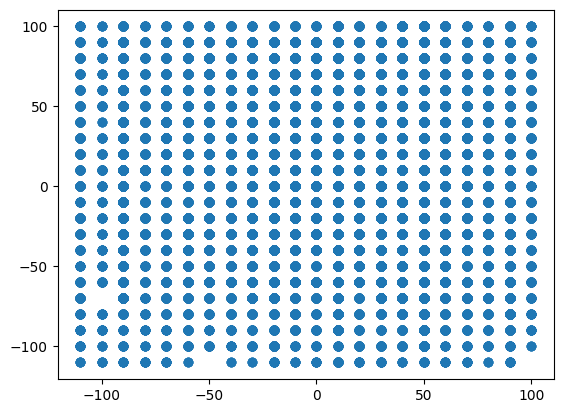

In [ ]:
inputs = model.input.to(device)
output = model.predict_image(input.float())
outputs = output.reshape((2, 81920))
plt.scatter(outputs[0], outputs[1])

In [38]:
torch.save(model, "model_avec_real_data_et_one_hot_encode_6epoch_val_setlr0.01.pth")

In [16]:
example_input = torch.randn(1, 1, 128, 128) .to(device)

writer = SummaryWriter('./logs')
writer.add_graph(model, example_input)
writer.close()

In [ ]:
for inputs, targets in data_loader_lab:
    target = targets
    break


# print(target_soft_encoded[0, : , 0,0])
target = np.zeros((target.shape[0], 310), dtype=np.float32)
soft_encoded = target.reshape(N, H, W, K).transpose(0, 3, 1, 2)

In [ ]:
ab_flat = torch.transpose(ab_batch, 1, 3).reshape(-1, 2)

In [ ]:
for inputs, targets in data_loader_lab:
    outputs = model.forward(inputs.float()).detach().numpy()
    target = targets.detach().numpy()
    break
inputs = inputs.detach().numpy()
print(np.max(outputs))
print(np.min(target))
max_L = 2.55
min_L =0
print(outputs.shape)
print(target.shape)

In [ ]:
print(inputs.shape)
image_recomposed = np.concatenate((inputs, outputs), axis = 1)
print(image_recomposed.shape)
image_recomposed = image_recomposed.astype(np.float32)
original_images = np.concatenate((inputs, target), axis = 1).astype(np.float32)
# rgb_image = cv2.cvtColor(image_recomposed, cv2.COLOR_Lab2RGB)

In [ ]:
num_images = 5
fig, axes = fig, axes = plt.subplots(2, num_images, figsize=(15, 10))

for i in range(num_images):
    original_lab_image = original_images[i]
    original_lab_image[0] = ((original_lab_image[0] - min_L) / (max_L -min_L))*100
    original_lab_image[1:] = original_lab_image[1:] *206  - 108
    lab_image = image_recomposed[i]
    lab_image[0] = ((lab_image[0] - min_L) / (max_L -min_L))*100
    lab_image[1:] = lab_image[1:] *206.1  - 107

    rgb_image = skimage.color.lab2rgb(lab_image.transpose(1, 2, 0))
    rgb_image_target = skimage.color.lab2rgb(original_lab_image.transpose(1, 2, 0))


    ax = axes[0, i]  # Première ligne
    ax.imshow(rgb_image)
    ax.axis('off')

    ax = axes[1, i]  # Deuxième ligne
    ax.imshow(rgb_image_target)
    ax.axis('off')

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphes pour éviter les chevauchements
plt.show()


In [ ]:
for inputs, targets in data_loader_lab:
  inputs = inputs.to(device)
  outputs = model.forward(inputs.float())
  print(outputs[3,:,10,10])
  ab_output = reverse_encode_ab_batch(outputs)
  target = targets
  break

tensor([3.4230e-08, 3.5346e-08, 3.4519e-08, 2.5769e-08, 6.8299e-08, 4.1903e-08,
        3.0487e-08, 2.0932e-08, 3.2632e-08, 2.7659e-08, 3.0062e-08, 2.9176e-08,
        2.9125e-08, 3.5071e-08, 4.5224e-08, 2.9908e-08, 2.4178e-08, 3.3744e-08,
        5.2757e-08, 2.6352e-08, 3.1984e-08, 3.8648e-08, 3.1624e-08, 3.0456e-08,
        3.0700e-08, 3.6955e-08, 3.7580e-08, 2.6780e-08, 3.1794e-08, 2.9001e-08,
        4.7607e-08, 3.2785e-08, 3.2670e-08, 4.3376e-08, 1.9814e-08, 2.3693e-08,
        4.0156e-08, 3.2842e-08, 3.6611e-08, 4.1533e-08, 2.4212e-08, 1.8683e-08,
        2.7214e-08, 2.2624e-08, 2.4922e-08, 7.7118e-08, 5.9562e-08, 3.7947e-08,
        2.7651e-08, 3.1067e-08, 2.3099e-08, 2.9658e-08, 2.4557e-08, 2.7828e-08,
        3.1363e-08, 2.7170e-08, 3.2475e-08, 4.4967e-08, 3.5793e-08, 2.5512e-08,
        3.2966e-08, 2.3599e-08, 2.8528e-08, 2.5222e-08, 2.8957e-08, 2.9801e-08,
        1.9875e-08, 2.3375e-08, 4.7001e-08, 2.7935e-08, 2.9416e-08, 3.2834e-08,
        2.3399e-08, 2.7731e-08, 3.4271e-

In [ ]:
print(targets.shape)
target = targets[0,:,:,:]
print(ab_output[0,:,:,:])
print(target.shape)
input = inputs[0,:,:,:]

torch.Size([4, 2, 128, 128])
[[[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]

 ...

 [[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ...
  [0 0]
  [0 0]
  [0 0]]]
torch.Size([2, 128, 128])


In [ ]:
soft = model.soft_encode_ab_batch(targets)
# a = torch.topk(soft, 5, dim=None, largest=True, sorted=True)
print(soft)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
print(a)

In [ ]:
print(ab_output)

[[[[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   ...
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]]

  [[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   ...
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]]

  [[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   ...
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]]

  ...

  [[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   ...
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]]

  [[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   ...
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.05731114]]

  [[-0.00675655  0.05731114]
   [-0.00675655  0.05731114]
   [-0.00675655  0.0

In [ ]:
print(outputs)

tensor([[[[9.4213e-06, 9.4213e-06, 1.1661e-05,  ..., 1.2792e-05,
           1.2792e-05, 1.0637e-05],
          [9.4213e-06, 9.4213e-06, 1.1661e-05,  ..., 1.2792e-05,
           1.2792e-05, 1.0637e-05],
          [1.0656e-05, 1.0656e-05, 1.3974e-05,  ..., 1.6450e-05,
           1.6450e-05, 1.2512e-05],
          ...,
          [1.0266e-05, 1.0266e-05, 1.2920e-05,  ..., 1.4353e-05,
           1.4353e-05, 1.1433e-05],
          [1.0266e-05, 1.0266e-05, 1.2920e-05,  ..., 1.4353e-05,
           1.4353e-05, 1.1433e-05],
          [9.1932e-06, 9.1932e-06, 1.0663e-05,  ..., 1.1444e-05,
           1.1444e-05, 9.9248e-06]],

         [[9.0637e-06, 9.0637e-06, 1.1665e-05,  ..., 1.3162e-05,
           1.3162e-05, 1.0596e-05],
          [9.0637e-06, 9.0637e-06, 1.1665e-05,  ..., 1.3162e-05,
           1.3162e-05, 1.0596e-05],
          [1.0537e-05, 1.0537e-05, 1.4742e-05,  ..., 1.8280e-05,
           1.8280e-05, 1.3007e-05],
          ...,
          [1.0211e-05, 1.0211e-05, 1.3740e-05,  ..., 1.5841

In [ ]:
print(model.cluster_centers)

[[ 1.10919767e+01  2.10851395e+01]
 [-5.06058053e-02  4.30818294e+00]
 [-7.69313216e+00  2.35050569e+01]
 [-3.38324910e+00 -2.59632024e+01]
 [ 3.63444671e+01  5.02150799e+01]
 [ 8.85347630e-01  4.57292420e+01]
 [-7.43011351e+00 -5.86057649e+00]
 [ 3.27345601e+01  9.93018014e+00]
 [-1.68028507e+01  3.26660747e+01]
 [ 4.08313224e+00  1.21855507e+01]
 [ 6.77572698e+00 -1.12207893e+01]
 [ 1.59490872e+01 -3.04037387e+01]
 [ 1.83289301e+01  3.70580869e+01]
 [ 8.89281100e-01 -2.44077415e+00]
 [ 1.21028434e+01  7.28909730e+00]
 [-1.10990727e+01  1.29362574e+01]
 [ 5.94491341e+01  4.69695496e+01]
 [ 8.71480619e-01  2.56434412e+01]
 [ 9.54336704e-01 -1.06201292e+01]
 [ 8.22071035e+00 -4.19501604e+01]
 [ 1.81222548e-01 -1.08131695e+00]
 [-4.39334350e+00  1.24895470e+01]
 [-1.21152887e+01  5.82706147e+01]
 [ 1.09448720e+01  4.07800249e+01]
 [-3.83786067e+01  5.85648805e+01]
 [ 1.33371222e+01  6.66070696e+01]
 [ 2.07325761e+01 -5.00380947e+01]
 [-2.00004677e+01  2.08396722e+01]
 [ 2.17289864e+01  6

In [ ]:
for inputs, targets in data_loader_lab:
    target_soft_encoded = model.soft_encode_ab_batch(targets)
    break

print(target_soft_encoded[10, : , 100,100])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [13]:

indices= np.arange(0,312, 2)
print(indices.shape)
new_cc = clusters[indices]

(156,)


In [14]:
print(new_cc)

[[ -90   50]
 [ -90   70]
 [ -90   90]
 [ -80   30]
 [ -80   50]
 [ -80   70]
 [ -80   90]
 [ -70   10]
 [ -70   30]
 [ -70   50]
 [ -70   70]
 [ -70   90]
 [ -60  -10]
 [ -60   10]
 [ -60   30]
 [ -60   50]
 [ -60   70]
 [ -60   90]
 [ -50  -20]
 [ -50    0]
 [ -50   20]
 [ -50   40]
 [ -50   60]
 [ -50   80]
 [ -50  100]
 [ -40  -30]
 [ -40  -10]
 [ -40   10]
 [ -40   30]
 [ -40   50]
 [ -40   70]
 [ -40   90]
 [ -30  -50]
 [ -30  -30]
 [ -30  -10]
 [ -30   10]
 [ -30   30]
 [ -30   50]
 [ -30   70]
 [ -30   90]
 [ -20  -50]
 [ -20  -30]
 [ -20  -10]
 [ -20   10]
 [ -20   30]
 [ -20   50]
 [ -20   70]
 [ -20   90]
 [ -10  -60]
 [ -10  -40]
 [ -10  -20]
 [ -10    0]
 [ -10   20]
 [ -10   40]
 [ -10   60]
 [ -10   80]
 [ -10  100]
 [   0  -60]
 [   0  -40]
 [   0  -20]
 [   0    0]
 [   0   20]
 [   0   40]
 [   0   60]
 [   0   80]
 [   0  100]
 [  10  -70]
 [  10  -50]
 [  10  -30]
 [  10  -10]
 [  10   10]
 [  10   30]
 [  10   50]
 [  10   70]
 [  10   90]
 [  20  -70]
 [  20  -50]